In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/ml_hw2")

<h3 style="text-align:center">
    In the name of God
</h3>
<p style="text-align:left">
    Machine Learning Course 1400, Dr. Sajedi
    <br>HW2
    <br>Alireza Kazemipour
    <br>610300171
</p>

In [3]:
!pip install nn-without-frameworks==0.0.14

In [4]:
%matplotlib inline

from nn_without_frameworks import numpy_nn as nn
from typing import List
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import time

In [5]:
dataset = pd.read_csv('pd_speech_features.csv', skiprows=[0], encoding="utf-8")
print(dataset.keys())

Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)


In [6]:
dataset_vals = dataset.values
X = dataset_vals[..., :-1]
Y = dataset_vals[..., -1]
n_class = int(np.max(Y) + 1)
n_feat = X.shape[-1]
print(f"input's shape: {X.shape}")
print(f"labels's shape: {Y.shape}")

input's shape: (756, 754)
labels's shape: (756,)


In [7]:
pos_class = np.sum(Y == 1)
neg_class = np.sum(Y == 0)
print(f"number of class 1 instances: {pos_class}")
print(f"number of class 0 instances: {neg_class}")
print(f"imbalance ratio:{max(pos_class / neg_class, neg_class / pos_class):.2f}")

number of class 1 instances: 564
number of class 0 instances: 192
imbalance ratio:2.94


In [8]:
cv_num = 5
seed = 123

In [9]:
np.random.seed(seed)
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

In [10]:
test_idx = np.random.permutation(len(X))[:int(0.1 * len(X))]
x_test = X[test_idx]
y_test = Y[test_idx]

X = np.delete(X, test_idx, axis=0)
Y = np.delete(Y, test_idx, axis=0)
full_batch_size = X.shape[0]

In [11]:
scaler = StandardScaler() 
X = scaler.fit_transform(X)

In [12]:
def choose_fold(x, y, n):
    for i in range(n):
        x_val = x[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]
        y_val = y[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]

        x_train = np.delete(x, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)
        y_train = np.delete(y, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)

        yield x_train, y_train, x_val, y_val

In [31]:
class AutoEncoder:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None,
                 random_state=int(time.time())
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.seed = random_state
        self.loss_fn = nn.losses.MSE()
        self.model = None
        self.best_weights = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        nn.seed(self.seed)
        best_loss = np.inf
        self.best_weights = None
        self.model = None
        n_feat = int(x.shape[-1])

        if self.model is None:
            hidden_units = self.hidden_units
            
            hidden_layers = []
            for i in range(len(hidden_units)):
                hidden_layers.append(nn.layers.Dense(in_features=n_feat,
                                           out_features=hidden_units[i],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.1),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                # hidden_layers.append(nn.layers.BatchNorm1d(hidden_units[i]))
                n_feat = hidden_units[i]

            if isinstance(hidden_layers[-1], nn.layers.BatchNorm1d):
                hidden_layers.pop(-1)             
            
            self.model = nn.Sequential(*hidden_layers)
        # self.model.summary()
        opt = self.opt(self.model.parameters, lr=self.lr)

        for step in range(self.epoch):
            y_pred = self.model(x)
            # print(y_pred.shape, y.shape)
            loss = self.loss_fn(y_pred, y)
            self.model.backward(loss)
            opt.apply()

            total_loss = loss.value
            total_loss += sum([0.5 * l.lam * np.sum(l.vars["W"] ** 2) for l in self.model._layers])

            if total_loss < best_loss:
              best_loss = total_loss
              self.best_weights = self.model.parameters


            if step == 0:
                self.loss_history.append(total_loss)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * total_loss)
            
    def predict(self, x):
        assert not self.model is None
        self.model.set_weights(self.best_weights)
        pred = self.model(x)
        return pred
    
    def model_architecture(self):
        self.model.summary() 

100%|██████████| 4/4 [19:37<00:00, 294.36s/it]


==> Auto Encoder <==
Training result:
	best param: lr = 0.001
	best validation loss = 0.37


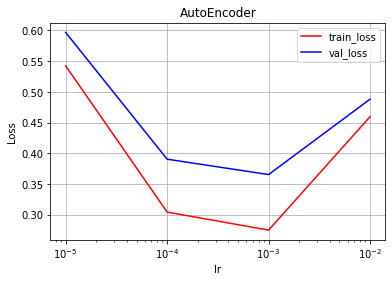


Model Summary:
+----------+----------------+----------+
| Layer    | Output shape   |   Param# |
+==========+================+==========+
| Input    | (None, 754)    |        0 |
+----------+----------------+----------+
| Dense[0] | (None, 256)    |   193280 |
+----------+----------------+----------+
| Dense[1] | (None, 754)    |   193778 |
+----------+----------------+----------+
total trainable parameters: 387058



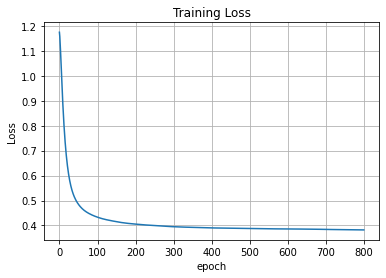


Test result: 

🎁🎁🎁test loss = 0.27.


In [40]:
clf = AutoEncoder(hidden_units=[256, X.shape[-1]],
                  epoch=800,
                  opt=nn.optims.Adam,
                  lam=1e-4,
                  reg_type="l2",
                  random_state=seed
                  )
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
history = {"train_loss": [], "val_loss": []}
best_val_loss = np.inf
best_param = None

for lr in tqdm(lrs):
    avg_val_loss = 0
    avg_train_loss = 0

    for x_train, y_train, x_val, y_val in choose_fold(X, X, cv_num):
        setattr(clf, "random_state", seed)
        setattr(clf, "lr", lr)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_train)
        avg_train_loss += clf.loss_fn(y_train, y_pred).value
        y_pred = clf.predict(x_val)
        avg_val_loss += clf.loss_fn(y_val, y_pred).value

    history["train_loss"].append(avg_train_loss / cv_num)
    history["val_loss"].append(avg_val_loss / cv_num)

    if history["val_loss"][-1] < best_val_loss:
        best_val_loss = history["val_loss"][-1]
        best_param = lr
        best_loss_hist = clf.loss_history

print("==> Auto Encoder <==")
print("Training result:")
print("\tbest param: {} = {}\n\tbest validation loss = {:.2f}".format("lr",
                                                                      best_param,
                                                                      best_val_loss))        
plt.plot(lrs, history["train_loss"], c="r")
plt.plot(lrs, history["val_loss"], c="b")
plt.legend(history.keys())
plt.grid()
plt.title("AutoEncoder")
plt.ylabel("Loss")
plt.xlabel("lr")
plt.xscale("log")
plt.show()

clf.model_architecture()
plt.plot()
plt.plot(range(clf.epoch), best_loss_hist)
plt.grid()
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()
    
print("\nTest result: ")
setattr(clf, "lr", best_param)
clf.fit(X, X)
x_test_stand = scaler.transform(x_test)
y_pred = clf.predict(x_test_stand)
test_loss = clf.loss_fn(x_test_stand, y_pred).value
        
print(f"\n🎁🎁🎁test loss = {test_loss:.2f}")

In [ ]:
-class NNClassifier:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None,
                 random_state=int(time.time())
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.seed = random_state
        self.bce_loss = nn.losses.BinaryCrossEntropy() # FocalLoss(gamma=0.2)
        self.model = None
        self.best_weights = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        nn.seed(self.seed)
        best_loss = np.inf
        self.best_weights = None
        self.model = None
        n_feat = int(x.shape[-1])
        # n_pos = np.sum(y == 1)
        # n_neg = np.sum(y == 0)

        if self.model is None:
            hidden_units = self.hidden_units
            
            hidden_layers = []
            for i in range(len(hidden_units)):
                hidden_layers.append(nn.layers.Dense(in_features=n_feat,
                                           out_features=hidden_units[i],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.1),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                hidden_layers.append(nn.layers.BatchNorm1d(hidden_units[i]))
                n_feat = hidden_units[i]

            if isinstance(hidden_layers[-1], nn.layers.BatchNorm1d):
                hidden_layers.pop(-1) 
            output_layer = nn.layers.Dense(in_features=self.hidden_units[-1],
                                      out_features=1,
                                      activation=nn.acts.Sigmoid(),
                                      weight_initializer=nn.inits.XavierUniform(),
                                      bias_initializer=nn.inits.Constant(0.01),
                                      regularizer_type=self.reg_type,
                                      lam=self.lam
                                      )
            
            
            self.model = nn.Sequential(*hidden_layers, output_layer)
        opt = self.opt(self.model.parameters, lr=self.lr)
            
        for step in range(self.epoch):
            y_pred = self.model(x)
            y_pred = y_pred.squeeze(-1)
            loss = self.bce_loss(y_pred, y)
            self.model.backward(loss)
            opt.apply()

            total_loss = loss.value
            total_loss += sum([0.5 * l.lam * np.sum(l.vars["W"] ** 2) for l in self.model._layers])

            if total_loss < best_loss:
              best_loss = total_loss
              self.best_weights = self.model.parameters


            if step == 0:
                self.loss_history.append(total_loss)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * total_loss)
            
    def predict(self, x):
        assert not self.model is None
        self.model.set_weights(self.best_weights)
        pred = self.model(x)
        return np.where(pred > 0.5, 1, 0).squeeze(-1)
    
    def model_architecture(self):
        self.model.summary() 

In [ ]:
class SingleLayerELMClassifier:
    def __init__(self,
                 units: int=64,
                 random_state=int(time.time())
                 ):
        """
        Reference:
        - [Introduction](https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b)
        - [code](https://github.com/burnpiro/elm-pure)
        """
        self.units = units
        self.seed = random_state
        self.beta = None
        self.H = None
        self.onehot_fn = OneHotEncoder(sparse=False)
        
    def fit(self, x, y):
        nn.seed(self.seed)
        self.beta = None
        self.H = None
        n_feat = int(x.shape[-1])
        # n_pos = np.sum(y == 1)
        # n_neg = np.sum(y == 0)

        if self.beta is None:
            self.H = nn.layers.Dense(in_features=n_feat,
                                  out_features=self.units,
                                  # activation=nn.acts.Tanh(),
                                  bias_initializer=nn.inits.RandomUniform()
                                  )
        H = self.H.forward(x)
        y = (y + 1).reshape(-1, 1)
        y = self.onehot_fn.fit_transform(y)
        
        self.beta = np.linalg.pinv(H).dot(y)
            
    def predict(self, x):
        assert not self.beta is None
        pred = self.H.forward(x).dot(self.beta)
        return np.argmax(pred, -1)

In [ ]:
class TwoHiddenLayerELMClassifier:
    def __init__(self,
                 units: int=64,
                 random_state=int(time.time())
                 ):
        """
        Reference:
        - [Introduction](Two-hidden-layer extreme learning machine for regression and classiﬁcation)
        - code: Implemented from scratch
        """
        self.units = units
        self.seed = random_state
        self.beta_new = None
        self.l1 = None
        self.l2 = None
        self.onehot_fn = OneHotEncoder(sparse=False)
        self.eps = 1e-6
        
    def fit(self, x, y):
        nn.seed(self.seed)
        self.beta_new = None
        self.l1 = None
        self.l2 = None
        n_feat = int(x.shape[-1])
        # n_pos = np.sum(y == 1)
        # n_neg = np.sum(y == 0)

        if self.beta_new is None:
            self.l1 = nn.layers.Dense(in_features=n_feat,
                                  out_features=self.units,
#                                   activation=nn.acts.Tanh(),
                                  bias_initializer=nn.inits.RandomUniform()
                                  )
            self.l2 = nn.layers.Dense(in_features=self.units,
                      out_features=self.units,
#                       activation=nn.acts.Tanh(),
                                      )
        y = (y + 1).reshape(-1, 1)
        y = self.onehot_fn.fit_transform(y)
        
        H = self.l1.forward(x)
        beta = np.linalg.pinv(H).dot(y)
        H1 = y.dot(np.linalg.pinv(beta))
#         H1 = np.clip(H1, -0.9, 0.9)
        HE = np.concatenate([np.ones(shape=(len(H), 1)), H], axis=-1)
        WHE = np.linalg.pinv(HE).dot(H1)
        H2 = HE.dot(WHE)
        
        self.beta_new = H2.T.dot(y)
        self.l2.vars['W'] = WHE[1:]
        self.l2.vars['b'] = WHE[0]
    def predict(self, x):
        assert not self.beta_new is None
        tmp = self.l1.forward(x)
        pred = self.l2.forward(tmp).dot(self.beta_new)
        return np.argmax(pred, -1)
    
#     def sigmoid(self, x):
#         return expit(x)
    
#     def sigmoid_inv(self, x):
# #         print(x)
#         return -np.log((1 - x) / (x + self.eps) + self.eps)

In [ ]:
clfs = {
#     "Neural Net 256": {"base_clf": NNClassifier(hidden_units=[256],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 128": {"base_clf": NNClassifier(hidden_units=[128],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64": {"base_clf": NNClassifier(hidden_units=[64],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64_32": {"base_clf": NNClassifier(hidden_units=[64, 32],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        }
# "Neural Net 256": {"base_clf": NNClassifier(hidden_units=[256],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 128": {"base_clf": NNClassifier(hidden_units=[128],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64": {"base_clf": NNClassifier(hidden_units=[64],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "SELM": {"base_clf": SingleLayerELMClassifier(random_state=seed
#                                                ),
#                        "param": "units",
#                        "param_values": 2 ** np.linspace(2, 9, num=8).astype(int)
#                        },
        "TELM": {"base_clf": TwoHiddenLayerELMClassifier(random_state=seed
                                               ),
                       "param": "units",
                       "param_values": 2 ** np.linspace(2, 9, num=8).astype(int)
                       }
        }

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.92it/s]

==> TELM <==
Training result:
	best param: units = 64
	best validation f1-score = 0.73


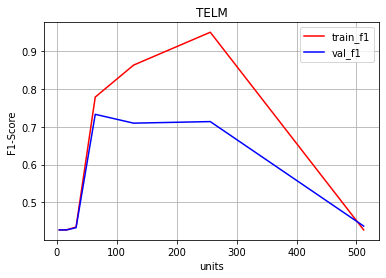


Test result: 


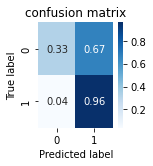

              precision    recall  f1-score   support

         0.0       0.75      0.33      0.46        18
         1.0       0.82      0.96      0.89        57

    accuracy                           0.81        75
   macro avg       0.79      0.65      0.67        75
weighted avg       0.80      0.81      0.78        75


🎁🎁🎁best_model is: TELM with test f1-score = 0.67%.


In [ ]:
best_test_f1 = -np.inf
best_model = {}

for clf_name, config in clfs.items():
    history = {"train_f1": [], "val_f1": []}
    best_val_f1 = 0
    best_param = None

    for p in tqdm(config["param_values"]):
        avg_val_f1 = 0
        avg_train_f1 = 0

        for x_train, y_train, x_val, y_val in choose_fold(X, Y, cv_num):
            clf = config["base_clf"]
            setattr(clf, "random_state", seed)
            setattr(clf, config["param"], p)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_train)
            avg_train_f1 += f1_score(y_train, y_pred, average='macro')
            y_pred = clf.predict(x_val)
            avg_val_f1 += f1_score(y_val, y_pred, average='macro')

        history["train_f1"].append(avg_train_f1 / cv_num)
        history["val_f1"].append(avg_val_f1 / cv_num)

        if history["val_f1"][-1] > best_val_f1:
            best_val_f1 = history["val_f1"][-1]
            best_param = p
            if "Neural Net" in clf_name:
                best_loss_hist = clf.loss_history

    print(f"==> {clf_name} <==")
    print("Training result:")
    print("\tbest param: {} = {}\n\tbest validation f1-score = {:.2f}".format(config["param"],
                                                                               best_param,
                                                                               best_val_f1))        
    plt.plot(config["param_values"], history["train_f1"], c="r")
    plt.plot(config["param_values"], history["val_f1"], c="b")
    plt.legend(history.keys())
    plt.grid()
    plt.title(clf_name)
    plt.ylabel("F1-Score")
    plt.xlabel(config["param"])
    if any(name in clf_name for name in ["SVM", "XGBoost", "Neural Net"]):
        plt.xscale("log")
    plt.show()
    
    if "Neural Net" in clf_name:
        clf.model_architecture()
        plt.plot()
        plt.plot(range(clf.epoch), best_loss_hist)
        plt.grid()
        plt.title("Training Loss")
        plt.ylabel("Loss")
        plt.xlabel("epoch")
        plt.show()
        
    print("\nTest result: ")
    setattr(clf, config["param"], best_param)
    clf.fit(X, Y)
    x_test_stand = scaler.transform(x_test)
    y_pred = clf.predict(x_test_stand)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model["name"] = clf_name
        best_model["clf"] = clf
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
    figure = plt.figure(figsize=(n_class, n_class))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    report = classification_report(y_test, y_pred)
    print(report)

    if clf_name == "Decision Tree":
        setattr(clfs["Random Forest"]["base_clf"], "max_depth", best_param)
        setattr(clfs["XGBoost"]["base_clf"], "max_depth", best_param)

    if clf_name == "Random Forest":
        setattr(clfs["XGBoost"]["base_clf"], "n_estimators", best_param)
        
print(f"\n🎁🎁🎁best_model is: {best_model['name']} with test f1-score = {best_test_f1:.2f}%.")